In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.feature_selection import RFECV

# EDA


In [4]:
df = pd.read_csv("ACME-HappinessSurvey2020.csv")

Let's do some exploratory data analysis


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


There are no missing data but the dataset is small. We should be careful with overfitting.

Let's check the class balance.


In [6]:
df["Y"].value_counts(normalize=True)

Y
1    0.547619
0    0.452381
Name: proportion, dtype: float64

55% are happy and 45% are unhappy. Seems pretty well balanced but this is misleading. More on that later.

For now let's see the summary statistics


In [38]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


We see that

- X1 has the largest mean (~4.33) and the lowest standard deviation (0.8), which means that satisfaction is high and variability is low. i.e. Most people are happy with little disagreement. X6 shows a similar case with a mean of ~ 4.25 and a std of ~0.81. Likewise for X4 with mean ~ 3.75 and std ~ 0.88.
- X2 on the other hand has the lowest mean (~2.53) with one of the highest std (~1.11) and a median of 3.0. Since median > mean, we have a left skewed distribution and it shows that the majority of the scores are low with some variability (some high scores). i.e. satisfaction is low.
- X5 is also left skewed but the mean is higher (~3.65) with the highest std (~ 1.15). Most people are happy but there seems to be a large division between happy and unhappy people here.

Let's check the distribution of the features by plotting them on bar plots


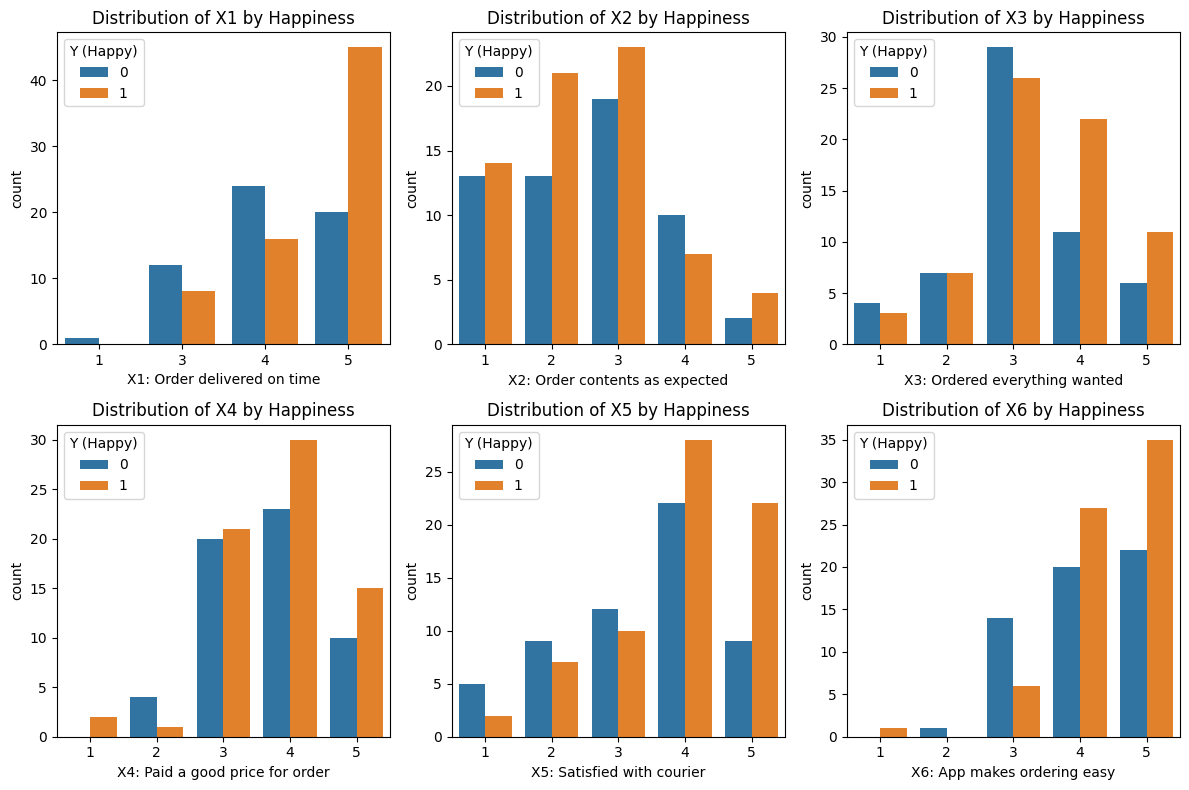

In [41]:
feature_explanations = {
    "X1": "X1: Order delivered on time",
    "X2": "X2: Order contents as expected",
    "X3": "X3: Ordered everything wanted",
    "X4": "X4: Paid a good price for order",
    "X5": "X5: Satisfied with courier",
    "X6": "X6: App makes ordering easy",
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(["X1", "X2", "X3", "X4", "X5", "X6"]):
    sns.countplot(data=df, x=col, hue="Y", ax=axes[i])
    axes[i].set_title(f"Distribution of {col} by Happiness")
    axes[i].set_xlabel(feature_explanations[col])
    axes[i].legend(title="Y (Happy)", loc="upper left")

plt.tight_layout()

As discussed earlier,

- Most people were happy about the app being easy to use (X6), paying a good price for their orders (X4) and orders being delivered on time (X1).
- Most people were unhappy because the content of their orders were not as expected (X2).

We also see that

- For X5, happy customers mostly rated their courier highly but the unhappy customers were more divided, explaining the high standard deviation from earlier.
- X3 is a bit of a mixed bag. Most people had a score of 3. If people were able to find the item that they wanted, they would be happy. Otherwise, they would be unhappy.


Let's validate this by looking at which features happy and unhappy customers differ the most as well as the correlation matrix


In [ ]:
df.groupby("Y").mean().T.assign(
    diff=lambda x: x[1] - x[0], corr_with_Y=df.corr()["Y"].drop("Y")
).sort_values("diff", ascending=False)

Y,0,1,diff,corr_with_Y
X5,3.368421,3.884058,0.515637,0.224522
X1,4.087719,4.536232,0.448513,0.280160
X3,3.140351,3.449275,0.308924,0.150838
X6,4.105263,4.376812,0.271548,0.167669
X4,3.684211,3.797101,0.112891,0.064415
X2,2.561404,2.507246,-0.054157,-0.024274


The biggest variance/gaps are with X1 (~0.45) and X5 (~0.52).

For X1, the mean scores for the unhappy customers are still relatively high whereas for X5, the unhappy customers are leaning towards middle-low.

These two features are also the ones which correlate highest with the target. That is, they are the most likely to predict happiness.

On the opposite end, X2 has the highest negative correlation with Y (but still ~0). Everyone rated it poorly, which means that fixing X2 might improve overall satisfaction but not necessarily convert unhappy customer to happy customers.


# Unhappy customers


Recall that 55% of the customers were happy and 45% of the customers were unhappy. The dataset seems well balanced.

However, even if the dataset might be balanced in general, in a business persepective, it is unbalanced.

45% of customers being unhappy is alarming and the company gains more from saving an unhappy customer.

<br>

From our analysis above, we already have a strong candidate: X2, but do we have any other features that can help us predict the truly unhappy customers?


In [12]:
unhappy_df = df[df["Y"] == 0]
happy_df = df[df["Y"] == 1]

In [13]:
unhappy_df.apply(lambda x: (x <= 2).sum()).sort_values(ascending=False)

Y     57
X2    26
X5    14
X3    11
X4     4
X1     1
X6     1
dtype: int64

Unhappy customers were most unhappy that their orders were not as expected (X2), that there was something wrong with their courier/delivery (X5) and that some items were out of stock (X3).

<br>

Now that we've identified what unhappy customers complain about most, let's find out which of these features actually predict unhappiness.

Instead of maximizing accuracy, we should maximize **recall** for class 0.

<br>

**Note**: Models predict customers as happy or unhappy. If the model predicts everyone as happy we would still achieve 55% accuracy but that would be useless to us since it did not find any unhappy customers. A model that predicts everyone as unhappy would achieve 45% accuracy but then it would not flag any happy customers.

Recall ensures we prioritize identifying truly unhappy customers.


# Modeling


### Split Dataset and model recall for class 0


We split the dataset into features and target so the model can learn: given a customer's response, predict whether they're happy or unhappy.


In [ ]:
X = df.drop("Y", axis=1)
y = df["Y"]

Instead of a traditional train/test split, we use cross validation since we have a very small dataset and want to avoid overfitting.

We compare recall using the following models:

- Logistic Regression since it's a good linear baseline
- Random Forest. Tree based ensemble, handles non-linear relationships
- Gradient Boosting. Tree based ensemble
- Support Vector Machine (SVM). Finds optimal decision boundaries, works well on small datasets


In [51]:
y_pred_log_reg = cross_val_predict(LogisticRegression(), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(), X, y)  # SVC is SVM but for classification

In [16]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier"
)

              precision    recall  f1-score   support

     Unhappy       0.48      0.42      0.45        57
       Happy       0.57      0.62      0.59        69

    accuracy                           0.53       126
   macro avg       0.52      0.52      0.52       126
weighted avg       0.53      0.53      0.53       126
 Logistic Regression
              precision    recall  f1-score   support

     Unhappy       0.46      0.40      0.43        57
       Happy       0.55      0.61      0.58        69

    accuracy                           0.52       126
   macro avg       0.51      0.51      0.50       126
weighted avg       0.51      0.52      0.51       126
 Random Forest
              precision    recall  f1-score   support

     Unhappy       0.51      0.49      0.50        57
       Happy       0.59      0.61      0.60        69

    accuracy                           0.56       126
   macro avg       0.55      0.55      0.55       126
weighted avg       0.55      0.56      0

For all models (class 0), the results are quite bad. Recall is below 50%.

However, this is our baseline. We might be able to improve by doing a few things like hyperparameter tuning.


### Hyperparameter Tuning


By default, models treat both classes equally. This means that with 55% happy and 45% unhappy, the model might lean towards predicting 'happy' more often.

We can try using class_weight='balanced' to adjust weights inversely proportional to class frequencies. That is, misclassifying an unhappy customer costs more than misclassifying a happy one.


In [17]:
y_pred_log_reg = cross_val_predict(LogisticRegression(class_weight="balanced"), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(class_weight="balanced"), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(class_weight="balanced"), X, y)

In [18]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression, balanced"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest, balanced"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier, balanced"
)

              precision    recall  f1-score   support

     Unhappy       0.53      0.56      0.55        57
       Happy       0.62      0.59      0.61        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression, balanced
              precision    recall  f1-score   support

     Unhappy       0.47      0.44      0.45        57
       Happy       0.56      0.59      0.58        69

    accuracy                           0.52       126
   macro avg       0.52      0.52      0.52       126
weighted avg       0.52      0.52      0.52       126
 Random Forest, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.47      0.49        57
       Happy       0.58      0.61      0.60        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0

Results are better this time with SVM having the best recall for class 0 at 0.61 from 0.37. But let's see if we can do even better.

What this means in practice is that we went from catching 21 out of 57 unhappy customers to catching 35 out of 57 customers.

<br>

Since SVM scale sensitive (uses distance to find decision boundaries), maybe we can try transforming the data with the standard scaler (removes mean and scaling to unit variance). i.e. mean=0, std=1.


In [52]:
svc_pipe = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(class_weight="balanced"))]
)

In [53]:
y_pred_svc_pipe = cross_val_predict(svc_pipe, X, y)
y_pred_log_reg = cross_val_predict(LogisticRegression(class_weight="balanced"), X, y)
y_pred_rf = cross_val_predict(RandomForestClassifier(class_weight="balanced"), X, y)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X, y)
y_pred_svc = cross_val_predict(SVC(class_weight="balanced"), X, y)

In [54]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression, balanced"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest, balanced"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier, balanced"
    + "\n"
    + classification_report(y, y_pred_svc_pipe, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier with standard scalar, balanced"
)

              precision    recall  f1-score   support

     Unhappy       0.53      0.56      0.55        57
       Happy       0.62      0.59      0.61        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.44      0.47        57
       Happy       0.58      0.64      0.61        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0.54      0.55      0.54       126
 Random Forest, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.47      0.49        57
       Happy       0.58      0.61      0.60        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0

That didn't help. SVM with the standard scaler resulted in worst results than SVM just with class_weight=balanced likely because our features are already on the same 1-5 scale.

Let's try something else. Using GridSearch, we might be able to find an optimal set of parameters to maximize performance.


In [55]:
param_grid = {
    "C": [
        0.01,
        0.1,
        1,
        10,
        100,
    ],  # Regularization parameter, low C = more regularization, allows more general decision boundary
    "kernel": ["linear", "rbf", "poly"],
}

scorer = make_scorer(recall_score, pos_label=0)

In [56]:
grid = GridSearchCV(
    SVC(class_weight="balanced"),
    param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'C': 0.01, 'kernel': 'poly'}
0.6681818181818182


GridSearch says that these are the best params: C=0.01 and a polynomial kernel and that recall improved from 0.61 to 0.67 (in the gridsearch realm).

Let's test this out with our actual model.


In [57]:
grid_searched_svc = SVC(C=0.01, kernel="poly", class_weight="balanced")
y_pred_grid_searched_svc = cross_val_predict(grid_searched_svc, X, y)

In [59]:
print(
    classification_report(y, y_pred_log_reg, target_names=["Unhappy", "Happy"])
    + " Logistic Regression, balanced"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest, balanced"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting"
    + "\n"
    + classification_report(y, y_pred_svc, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier, balanced"
    + "\n"
    + classification_report(y, y_pred_svc_pipe, target_names=["Unhappy", "Happy"])
    + " Support Vector Classifier with standard scalar, balanced"
    + "\n"
    + classification_report(
        y, y_pred_grid_searched_svc, target_names=["Unhappy", "Happy"]
    )
    + "Support Vector Classifier with grid search parameters, balanced"
)

              precision    recall  f1-score   support

     Unhappy       0.53      0.56      0.55        57
       Happy       0.62      0.59      0.61        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.44      0.47        57
       Happy       0.58      0.64      0.61        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0.54      0.55      0.54       126
 Random Forest, balanced
              precision    recall  f1-score   support

     Unhappy       0.50      0.47      0.49        57
       Happy       0.58      0.61      0.60        69

    accuracy                           0.55       126
   macro avg       0.54      0.54      0.54       126
weighted avg       0

Grid search gives us a result of 0.60 for recall, which is not bad but does not really add much compared to the original SVM with class_weight=balanced.


### Feature Analysis/Importance


In [26]:
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X, y)
model.feature_importances_

array([0.16472393, 0.17673734, 0.19256142, 0.15568595, 0.17461987,
       0.1356715 ])

<Axes: >

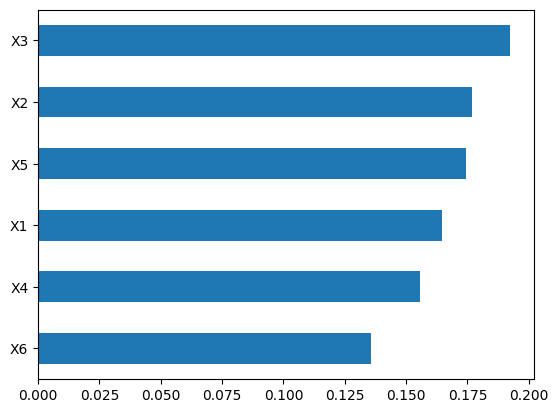

In [27]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh")

### Feature Engineering - Minimal Feature Set


In [28]:
rfecv = RFECV(
    estimator=RandomForestClassifier(class_weight="balanced", random_state=42),
    scoring=make_scorer(recall_score, pos_label=0),
    cv=5,
)

rfecv.fit(X, y)

,estimator estimator: ``Estimator`` instanceA supervised learning estimator with a ``fit`` method that providesinformation about feature importance either through a ``coef_``attribute or through a ``feature_importances_`` attribute.,RandomForestC...ndom_state=42)
,"step step: int or float, default=1If greater than or equal to 1, then ``step`` corresponds to the(integer) number of features to remove at each iteration.If within (0.0, 1.0), then ``step`` corresponds to the percentage(rounded down) of features to remove at each iteration.Note that the last iteration may remove fewer than ``step`` features inorder to reach ``min_features_to_select``.",1
,"min_features_to_select min_features_to_select: int, default=1The minimum number of features to be selected. This number of featureswill always be scored, even if the difference between the originalfeature count and ``min_features_to_select`` isn't divisible by``step``... versionadded:: 0.20",1
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If theestimator is not a classifier or if ``y`` is neither binary nor multiclass,:class:`~sklearn.model_selection.KFold` is used.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value of None changed from 3-fold to 5-fold.",5
,"scoring scoring: str or callable, default=NoneScoring method to evaluate the :class:`RFE` selectors' performance. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.","make_scorer(r..., pos_label=0)"
,"verbose verbose: int, default=0Controls verbosity of output.",0
,"n_jobs n_jobs: int or None, default=NoneNumber of cores to run in parallel while fitting across folds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"importance_getter importance_getter: str or callable, default='auto'If 'auto', uses the feature importance either through a `coef_`or `feature_importances_` attributes of estimator.Also accepts a string that specifies an attribute name/pathfor extracting feature importance.For example, give `regressor_.coef_` in case of:class:`~sklearn.compose.TransformedTargetRegressor` or`named_steps.clf.feature_importances_` in case of:class:`~sklearn.pipeline.Pipeline` with its last step named `clf`.If `callable`, overrides the default feature importance getter.The callable is passed with the fitted estimator and it shouldreturn importance for each feature... versionadded:: 0.24",'auto'
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None


In [29]:
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", X.columns[rfecv.support_].tolist())
print("Feature ranking:", dict(zip(X.columns, rfecv.ranking_)))

Optimal number of features: 2
Selected features: ['X2', 'X5']
Feature ranking: {'X1': np.int64(2), 'X2': np.int64(1), 'X3': np.int64(3), 'X4': np.int64(4), 'X5': np.int64(1), 'X6': np.int64(5)}


In [30]:
rfecv_gb = RFECV(
    estimator=GradientBoostingClassifier(random_state=42),
    scoring=make_scorer(recall_score, pos_label=0),
    cv=5,
)
rfecv_gb.fit(X, y)
print("Selected features:", X.columns[rfecv_gb.support_].tolist())
print("Optimal number of features:", rfecv_gb.n_features_)


Selected features: ['X1', 'X3', 'X5', 'X6']
Optimal number of features: 4


After looking at the minimal set of features that preserves recall, we see that for random forest, only X2 and X5 are necessary. For Gradient boost, only X1, X3, X5 and X6 are necessary.

Let's try retraining our models with only the two features first then with only the four features.


In [31]:
X_reduced = X[["X2", "X5"]]
y_pred_reduced_svc = cross_val_predict(SVC(class_weight="balanced"), X_reduced, y)
y_pred_reduced_lr = cross_val_predict(
    LogisticRegression(class_weight="balanced"), X_reduced, y
)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X_reduced, y)
y_pred_rf = cross_val_predict(
    RandomForestClassifier(class_weight="balanced"), X_reduced, y
)

In [32]:
print(
    classification_report(y, y_pred_reduced_svc, target_names=["Unhappy", "Happy"])
    + " SVC on Reduced Features (2 Features)"
    + "\n"
    + classification_report(y, y_pred_reduced_lr, target_names=["Unhappy", "Happy"])
    + " Logistic Regression on Reduced Features (2 Features)"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting on Reduced Features (2 Features)"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest on Reduced Features (2 Features)"
)

              precision    recall  f1-score   support

     Unhappy       0.52      0.53      0.52        57
       Happy       0.60      0.59      0.60        69

    accuracy                           0.56       126
   macro avg       0.56      0.56      0.56       126
weighted avg       0.56      0.56      0.56       126
 SVC on Reduced Features (2 Features)
              precision    recall  f1-score   support

     Unhappy       0.51      0.46      0.48        57
       Happy       0.59      0.64      0.61        69

    accuracy                           0.56       126
   macro avg       0.55      0.55      0.55       126
weighted avg       0.55      0.56      0.55       126
 Logistic Regression on Reduced Features (2 Features)
              precision    recall  f1-score   support

     Unhappy       0.52      0.40      0.46        57
       Happy       0.59      0.70      0.64        69

    accuracy                           0.56       126
   macro avg       0.55      0.55     

We see with this minimal set, that the highest recall is from random forest with 0.6 (class 0).

The highest recall overall was from svc (class_weight=balance) with 0.61. But this was with all 6 features.


In [33]:
X_reduced = X[["X1", "X5", "X3", "X6"]]
y_pred_reduced_svc = cross_val_predict(SVC(class_weight="balanced"), X_reduced, y)
y_pred_reduced_lr = cross_val_predict(
    LogisticRegression(class_weight="balanced"), X_reduced, y
)
y_pred_gb = cross_val_predict(GradientBoostingClassifier(), X_reduced, y)
y_pred_rf = cross_val_predict(
    RandomForestClassifier(class_weight="balanced"), X_reduced, y
)

In [34]:
print(
    classification_report(y, y_pred_reduced_svc, target_names=["Unhappy", "Happy"])
    + " SVC on Reduced Features (4 Features)"
    + "\n"
    + classification_report(y, y_pred_reduced_lr, target_names=["Unhappy", "Happy"])
    + " Logistic Regression on Reduced Features (4 Features)"
    + "\n"
    + classification_report(y, y_pred_gb, target_names=["Unhappy", "Happy"])
    + " Gradient Boosting on Reduced Features (4 Features)"
    + "\n"
    + classification_report(y, y_pred_rf, target_names=["Unhappy", "Happy"])
    + " Random Forest on Reduced Features (4 Features)"
)

              precision    recall  f1-score   support

     Unhappy       0.55      0.67      0.60        57
       Happy       0.67      0.55      0.60        69

    accuracy                           0.60       126
   macro avg       0.61      0.61      0.60       126
weighted avg       0.61      0.60      0.60       126
 SVC on Reduced Features (4 Features)
              precision    recall  f1-score   support

     Unhappy       0.53      0.58      0.55        57
       Happy       0.62      0.58      0.60        69

    accuracy                           0.58       126
   macro avg       0.58      0.58      0.58       126
weighted avg       0.58      0.58      0.58       126
 Logistic Regression on Reduced Features (4 Features)
              precision    recall  f1-score   support

     Unhappy       0.64      0.60      0.62        57
       Happy       0.68      0.72      0.70        69

    accuracy                           0.67       126
   macro avg       0.66      0.66     

We see that both minimal sets have the same results. So it's safe to say that we can just use the 2 feature minimal set.


# Conclusion


- In the original dataset, 45% of customers were unhappy, which was alarming since there should not be so many.
- We shifted to only look at unhappy customers. The top complaints were X2: orders not matching expectations, X5: courier dissatisfaction and X3: items being out of stock.
- We then tested 4 models optimizing for recall on class 0 (unhappy). Recall was used instead of accuracy since it is more valuable to catch unhappy customers than being correct overall.
- SVC with balanced class weights performed best at 0.61 recall (with all 6 features)
- RFECV was used to find a minimal set out of all 6 features. It found that only X2 and X5 were necessary to predict unhappiness.
